In [5]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
import numpy.linalg as LA
import seaborn as sns
from sklearn.linear_model import LinearRegression
from abc import ABC, abstractmethod

In [18]:
class RefractTrace():

    def __init__(self, xt_pairs: list):

        # Unpack x-t pairs to separate arrays
        self.x, self.t = xt_pairs.T

        self.num_geophones = len(self.x)
        self.t_calculated = self.t.copy() # initialize

    def setup_model(self, xt_breaks: list):
        self.num_segments = len(xt_breaks) + 1

        # labels for plotting
        self.label = [f'Refracted Wave {i}' for i in range(self.num_segments)]
        self.label[0] = 'Direct Wave'
        self.label_code = np.zeros(self.num_geophones)

        # Model boundaries
        self.num_segments = len(xt_breaks) + 1
        self.xt_breaks = np.concatenate(([0], xt_breaks, [self.num_geophones]))

        # Initialize model (interpretation) variables
        self.velocity = np.zeros(self.num_segments)
        self.thickness = np.zeros(self.num_segments)

    def velocity_func(self, k, n):
        vk = self.velocity[k]
        vn = self.velocity[n]
        if isclose(vn, vk, rel_tol=0.000001):
            raise ValueError('One or more layer boundaries does not reflect a noticeable velocity contrast. Try removing boundaries.')
        elif vn < vk:
            raise ValueError('Critical refraction cannot occur.')
        else:
            return sqrt(vn ** 2 - vk ** 2) / (vn * vk)

    def model(self):
        self.hidden = False
        self.num_layers = self.num_segments

        # Regression & Layer thickness(es)
        for k in range(self.num_segments):

            # Define x, t interval for regression
            start, stop = self.xt_breaks[k], self.xt_breaks[k+1]
            x_segment, t_segment = self.x[start:stop], self.t[start:stop]

            # Linear regression matrix
            x_matrix = np.column_stack([x_segment, np.ones(len(x_segment))])

            # Perform regression using scikit-learn
            reg = LinearRegression(fit_intercept = (k > 0)) # t_int = 0 if k = 0
            reg.fit(x_matrix, t_segment)
        
            # Add calculated variables to corresponding layer 
            self.velocity[k] = 1 / reg.coef_[0]

            # Calculate overlying layer thickness
            sum_term = np.sum([2 * self.thickness[j] * self.velocity_func(j, k) for j in range(k - 1)]) # range() is already exclusive of upper bound, hence k - 2 isn't right
            self.thickness[k-1] = (reg.intercept_ - sum_term) / (2 * self.velocity_func(k - 1, k))

            # Calculate regression t values for geophones in this segment
            self.t_calculated[start:stop] = [reg.coef_[0] * x + reg.intercept_ for x in x_segment]

            self.label_code[start:stop] = k

    def model_hidden_layer(self, depth_to_hidden, hidden_layer_velocity):
        self.hidden = True

        self.num_layers = self.num_segments + 1
        self.hidden_layer_velocity = hidden_layer_velocity
        self.depth_to_hidden = depth_to_hidden

        self.velocity = np.insert(self.velocity, 1, self.hidden_layer_velocity)
        self.thickness_naive = np.insert(self.thickness, 1, 0) 
        self.hidden_thickness = self.velocity_func(0, -1) * (self.thickness[0] - self.depth_to_hidden) / self.velocity_func(1, -1)
        self.thickness = np.insert(self.thickness, 1, self.hidden_thickness)

        self.thickness[0] = self.depth_to_hidden

    def plot(self):

        # Set up Labeling
        self.label_obs = [f'{self.label[int(i)]}' for i in self.label_code]
        self.label_calc = [f'$V_{int(i)+1}$: {round(self.velocity[int(i)+self.hidden])} m/s' for i in self.label_code]

        # Define figure dimensions
        fig = plt.figure(figsize=(9, 6), dpi=600)
        ax1 = fig.add_subplot(10,2,(1,17))
        ax2 = fig.add_subplot(10,2,19)
        ax3 = fig.add_subplot(10,2,(2,20))
        
        # Trace and linear fit plot
        ax1.set_title("First Return Data")
        sns.scatterplot(x = self.x, y = self.t, hue = self.label_obs, ax=ax1)
        sns.lineplot(x = self.x, y = self.t_calculated, hue = self.label_calc,ax=ax1)
        ax1.set_ylabel('Time (ms)')
        ax1.set_ylim([0, None])
        ax1.set(xticklabels=[])
        time_ticks = ax1.get_yticks()
        ax1.set_yticklabels([int(1000*tick) for tick in time_ticks])        

        # Residual plot
        ax2.set_ylabel('Res.')
        sns.scatterplot(x = self.x, y = (self.t - self.t_calculated), hue = self.label_obs, legend=False, ax=ax2)
        ax2.set(yticklabels=[])  # remove the tick labels
        ax2.tick_params(left=False,top=True)  # remove the ticks
        ax2.set_xlabel('Distance (m)')

        bottom_layer_multiplier = 0.1
        label_box_pad = 4

        if not self.hidden:

            # Single barplot
            self.thickness[-1] = bottom_layer_multiplier * sum(self.thickness[:-1])
            labels = [""]

            for k in range(self.num_layers):
                has_depth = k + 1 < self.num_layers
                ax3.bar(labels, 
                -self.thickness[k], 
                # label=f"$V_{i+1}$: {round(self.velocity[i])} m/s", 
                bottom=-sum(self.thickness[:k]))

                # label center of each layer with V and H
                ax3.text(0, -sum(self.thickness[:k]) - self.thickness[k]/2,
                f"$V_{k+1}$: {round(self.velocity[k])} m/s" + has_depth * "\n" + has_depth * f"$H_{k+1}$: {round(self.thickness[k],1)} m",
                verticalalignment='center',
                horizontalalignment='center',
                bbox={'facecolor': 'white', 'pad': label_box_pad})
        else:

            # Define bottom layer thickness for plotting
            self.thickness_naive[-1] = bottom_layer_multiplier * sum(self.thickness_naive[:-1])
            self.thickness[-1] = sum(self.thickness_naive) - sum(self.thickness[:-1])
            labels = ["Apparent", "Actual"]

            for k in range(self.num_layers):
                has_depth = k + 1 < self.num_layers
                ax3.bar(labels, 
                [
                    -self.thickness_naive[k],
                    -self.thickness[k]
                ],
                label=f"$V_{k+1}$: {round(self.velocity[k])} m/s", 
                bottom = [ # "bottom" = closest to zero (top bc inverted)
                    -sum(self.thickness_naive[:k]),
                    -sum(self.thickness[:k])
                ])

                if k != 1:
                    ax3.text(0, -sum(self.thickness_naive[:k]) - self.thickness_naive[k]/2,
                    f"$V_{k+1}$: {round(self.velocity[k])} m/s" + has_depth * "\n" + has_depth * f"$H_{k+1}$: {round(self.thickness_naive[k],1)} m",
                    verticalalignment='center',
                    horizontalalignment='center',
                    bbox={'facecolor': 'white', 'pad': label_box_pad})

                ax3.text(1, -sum(self.thickness[:k]) - self.thickness[k]/2,
                f"$V_{k+1}$: {round(self.velocity[k])} m/s" + has_depth * "\n" + has_depth * f"$H_{k+1}$: {round(self.thickness[k],1)} m",
                verticalalignment='center',
                horizontalalignment='center',
                bbox={'facecolor': 'white', 'pad': label_box_pad})

        ax3.yaxis.set_label_position("right")
        ax3.tick_params(bottom = False, left = True, right = True, labelright=True)

        depth_ticks = ax3.get_yticks()
        ax3.set_yticklabels([int(abs(tick)) for tick in depth_ticks])
            
        ax3.set_ylabel('Depth (m)')
        ax3.set_title('Subsurface Model')

    def print_model(self):
        for k in range(self.num_layers):
            print(f"Layer {k+1}: Thickness = {self.thickness[k]} Velocity = {self.velocity[k]} m")
        print('Note that bottom layer thickness is as shown on the model, this number could be theoretically infinite.')

    def write_file_for_REFRACT(self, filename_str):

        self.shot_offset = self.x[0]
        self.geophone_spacing = self.x[1] - self.x[0]

        # File Preamble
        lines = [
            f"NumberGeophones,{self.num_geophones}",
            f"ShotOffset,{self.shot_offset}",
            f"GeophoneSpacing,{self.geophone_spacing}",
            f"FirstGeophone,0",
        ]

        # Data entries
        for i in range(self.num_geophones):
            lines.append(f"Time,{i},{self.t[i]},{self.t[-(i+1)]}")

        # Write file
        with open(f'{filename_str}.txt', 'w') as f:
            for line in lines:
                f.write(line)
                f.write('\n')

<ipython-input-18-761c0265479e>:35: RuntimeWarning: divide by zero encountered in double_scalars
  return sqrt(vn ** 2 - vk ** 2) / (vn * vk)
<ipython-input-18-761c0265479e>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([int(1000*tick) for tick in time_ticks])
<ipython-input-18-761c0265479e>:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([int(abs(tick)) for tick in depth_ticks])


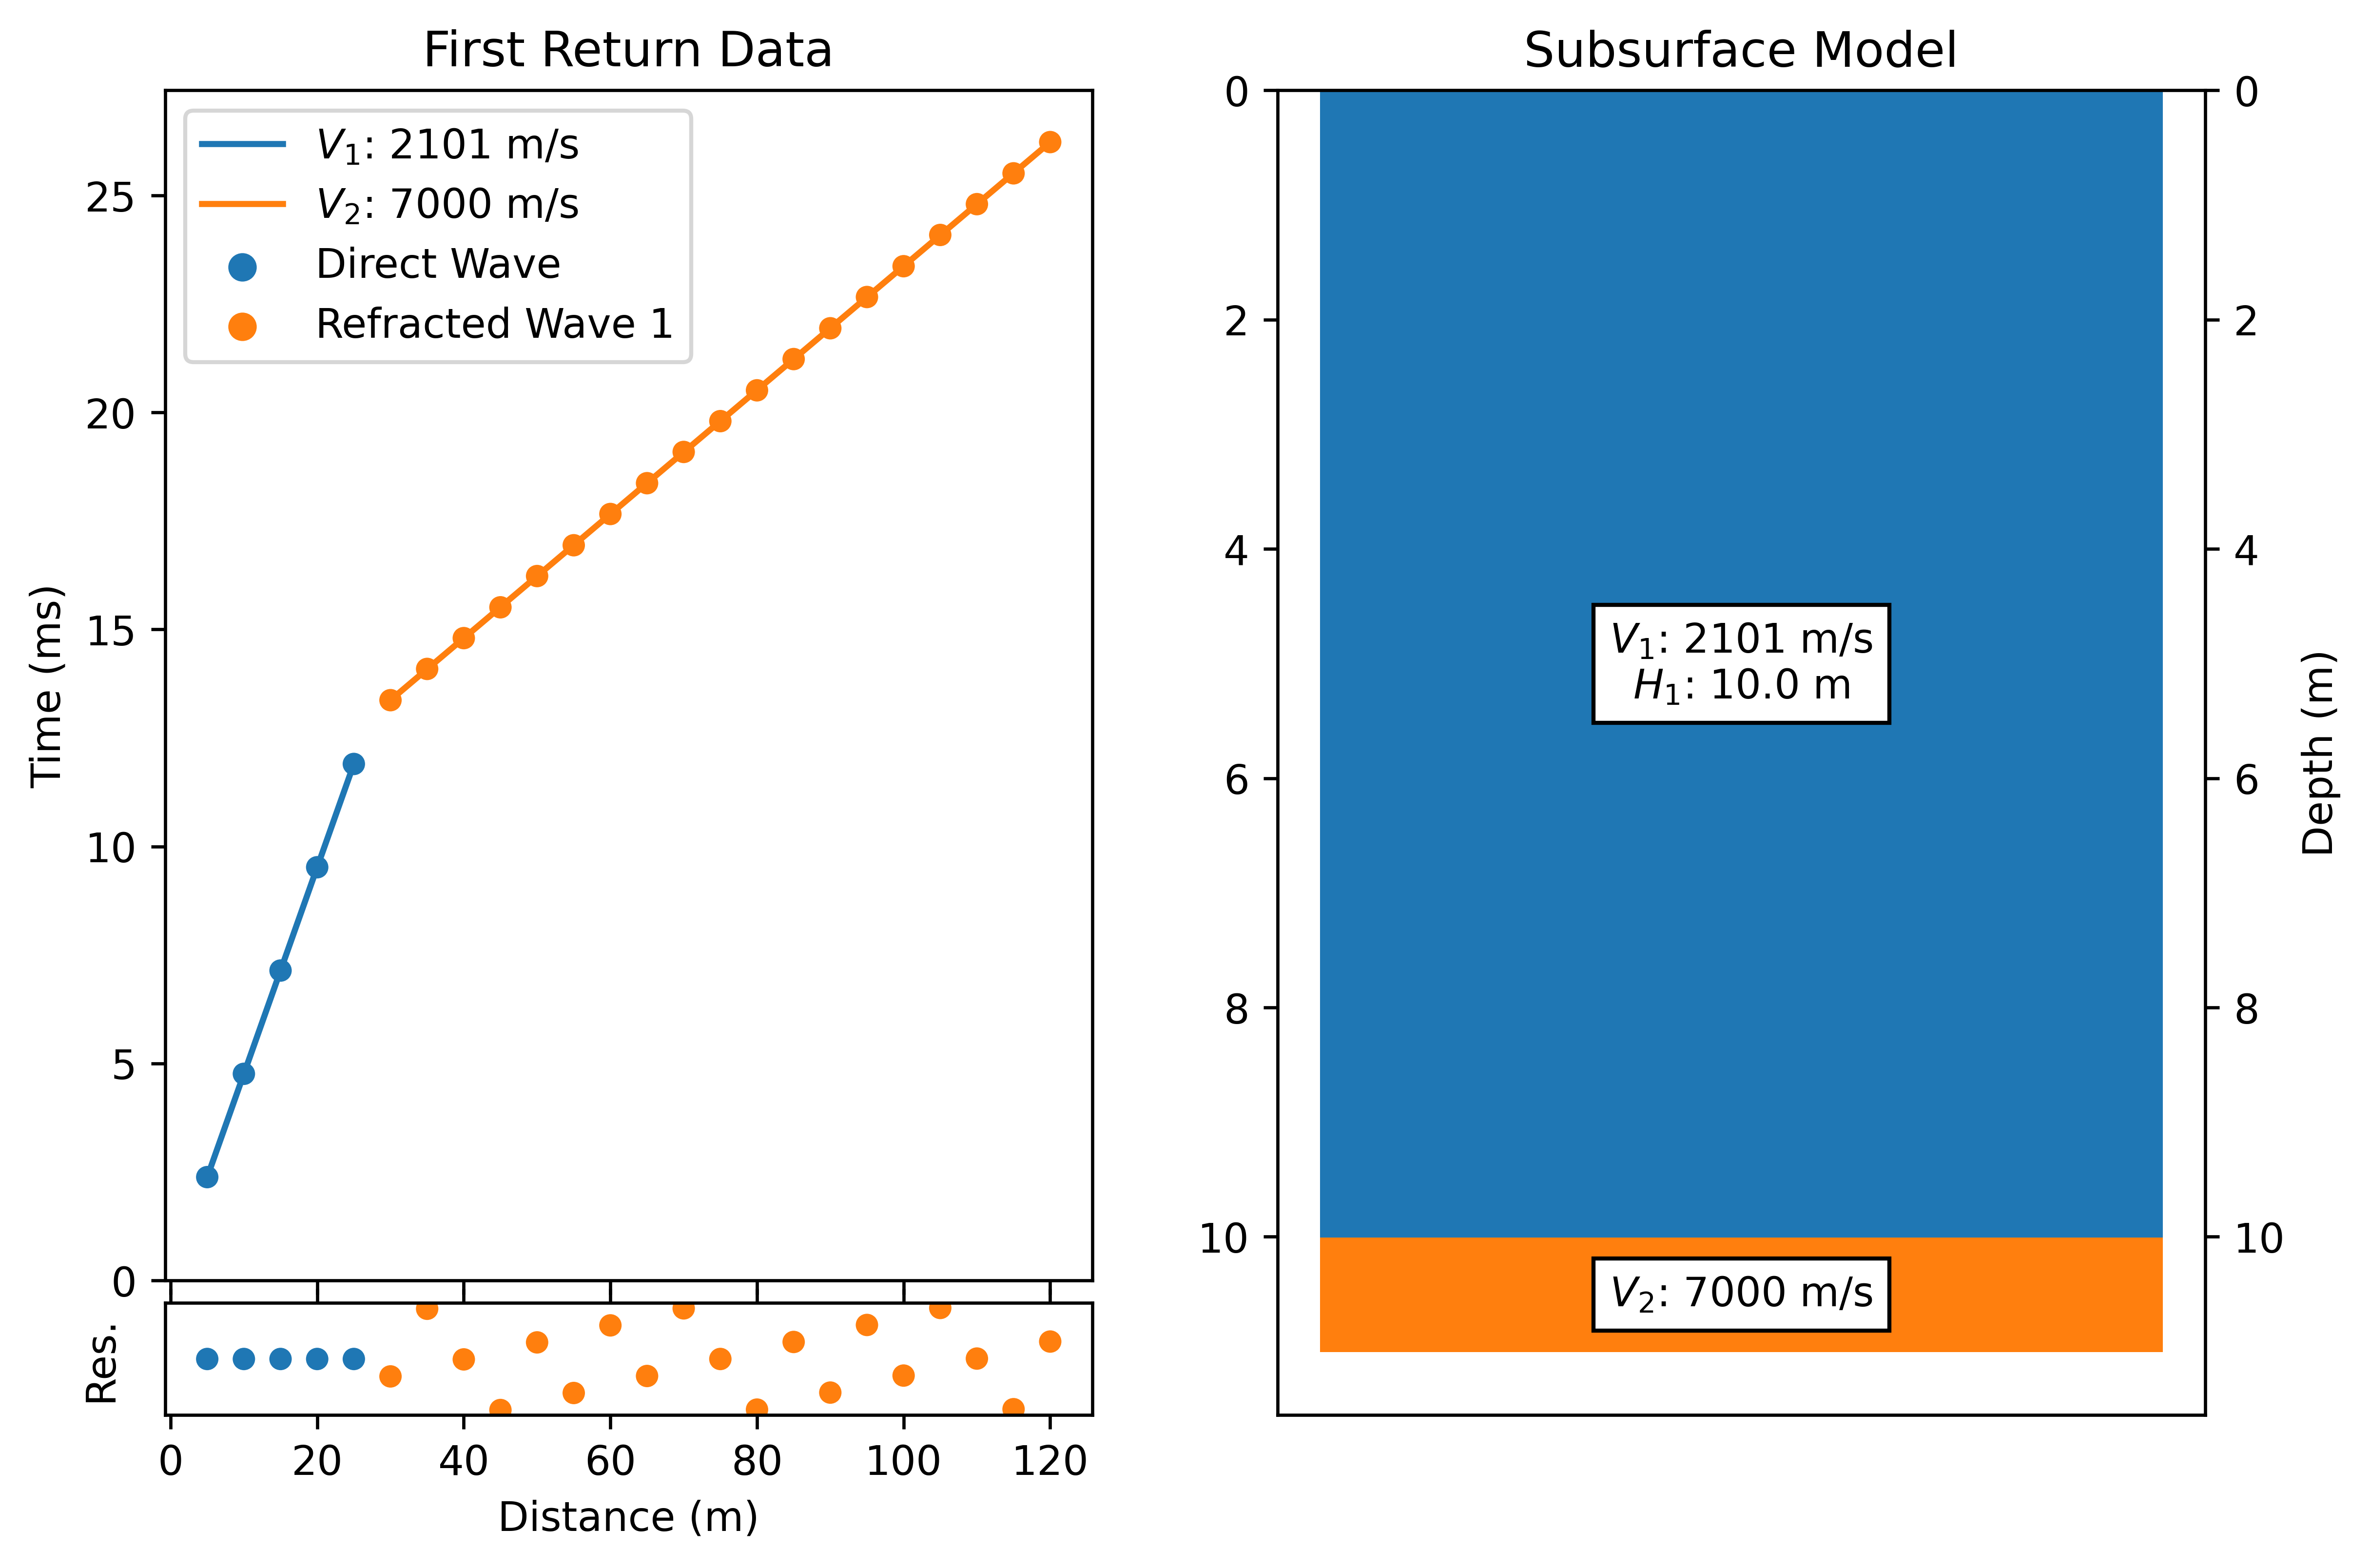

In [19]:
data_Q2 = np.array([
[5,     2.38],
[10,	4.76],
[15,	7.14],
[20,	9.52],
[25,	11.9],
[30,	13.37],
[35,	14.09],
[40,	14.8],
[45,	15.51],
[50,	16.23],
[55,	16.94],
[60,	17.66],
[65,	18.37],
[70,	19.09],
[75,	19.8],
[80,	20.51],
[85,	21.23],
[90,	21.94],
[95,	22.66],
[100,	23.37],
[105,	24.09],
[110,	24.8],
[115,	25.51],
[120,	26.23]])

# convert ms to s
data_Q2[:,1] = data_Q2[:,1] / 1000

trace_Q2 = RefractTrace(data_Q2)

trace_Q2.setup_model(xt_breaks=[5])
trace_Q2.model()
trace_Q2.plot()

<ipython-input-18-761c0265479e>:35: RuntimeWarning: divide by zero encountered in double_scalars
  return sqrt(vn ** 2 - vk ** 2) / (vn * vk)
<ipython-input-18-761c0265479e>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([int(1000*tick) for tick in time_ticks])
<ipython-input-18-761c0265479e>:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([int(abs(tick)) for tick in depth_ticks])


Layer 1: Thickness = 3.0 Velocity = 1802.8846153846155 m
Layer 2: Thickness = 9.897432706020219 Velocity = 1200.0 m
Layer 3: Thickness = 0.0 Velocity = 5882.352941176481 m
Note that bottom layer thickness is as shown on the model, this number could be theoretically infinite.


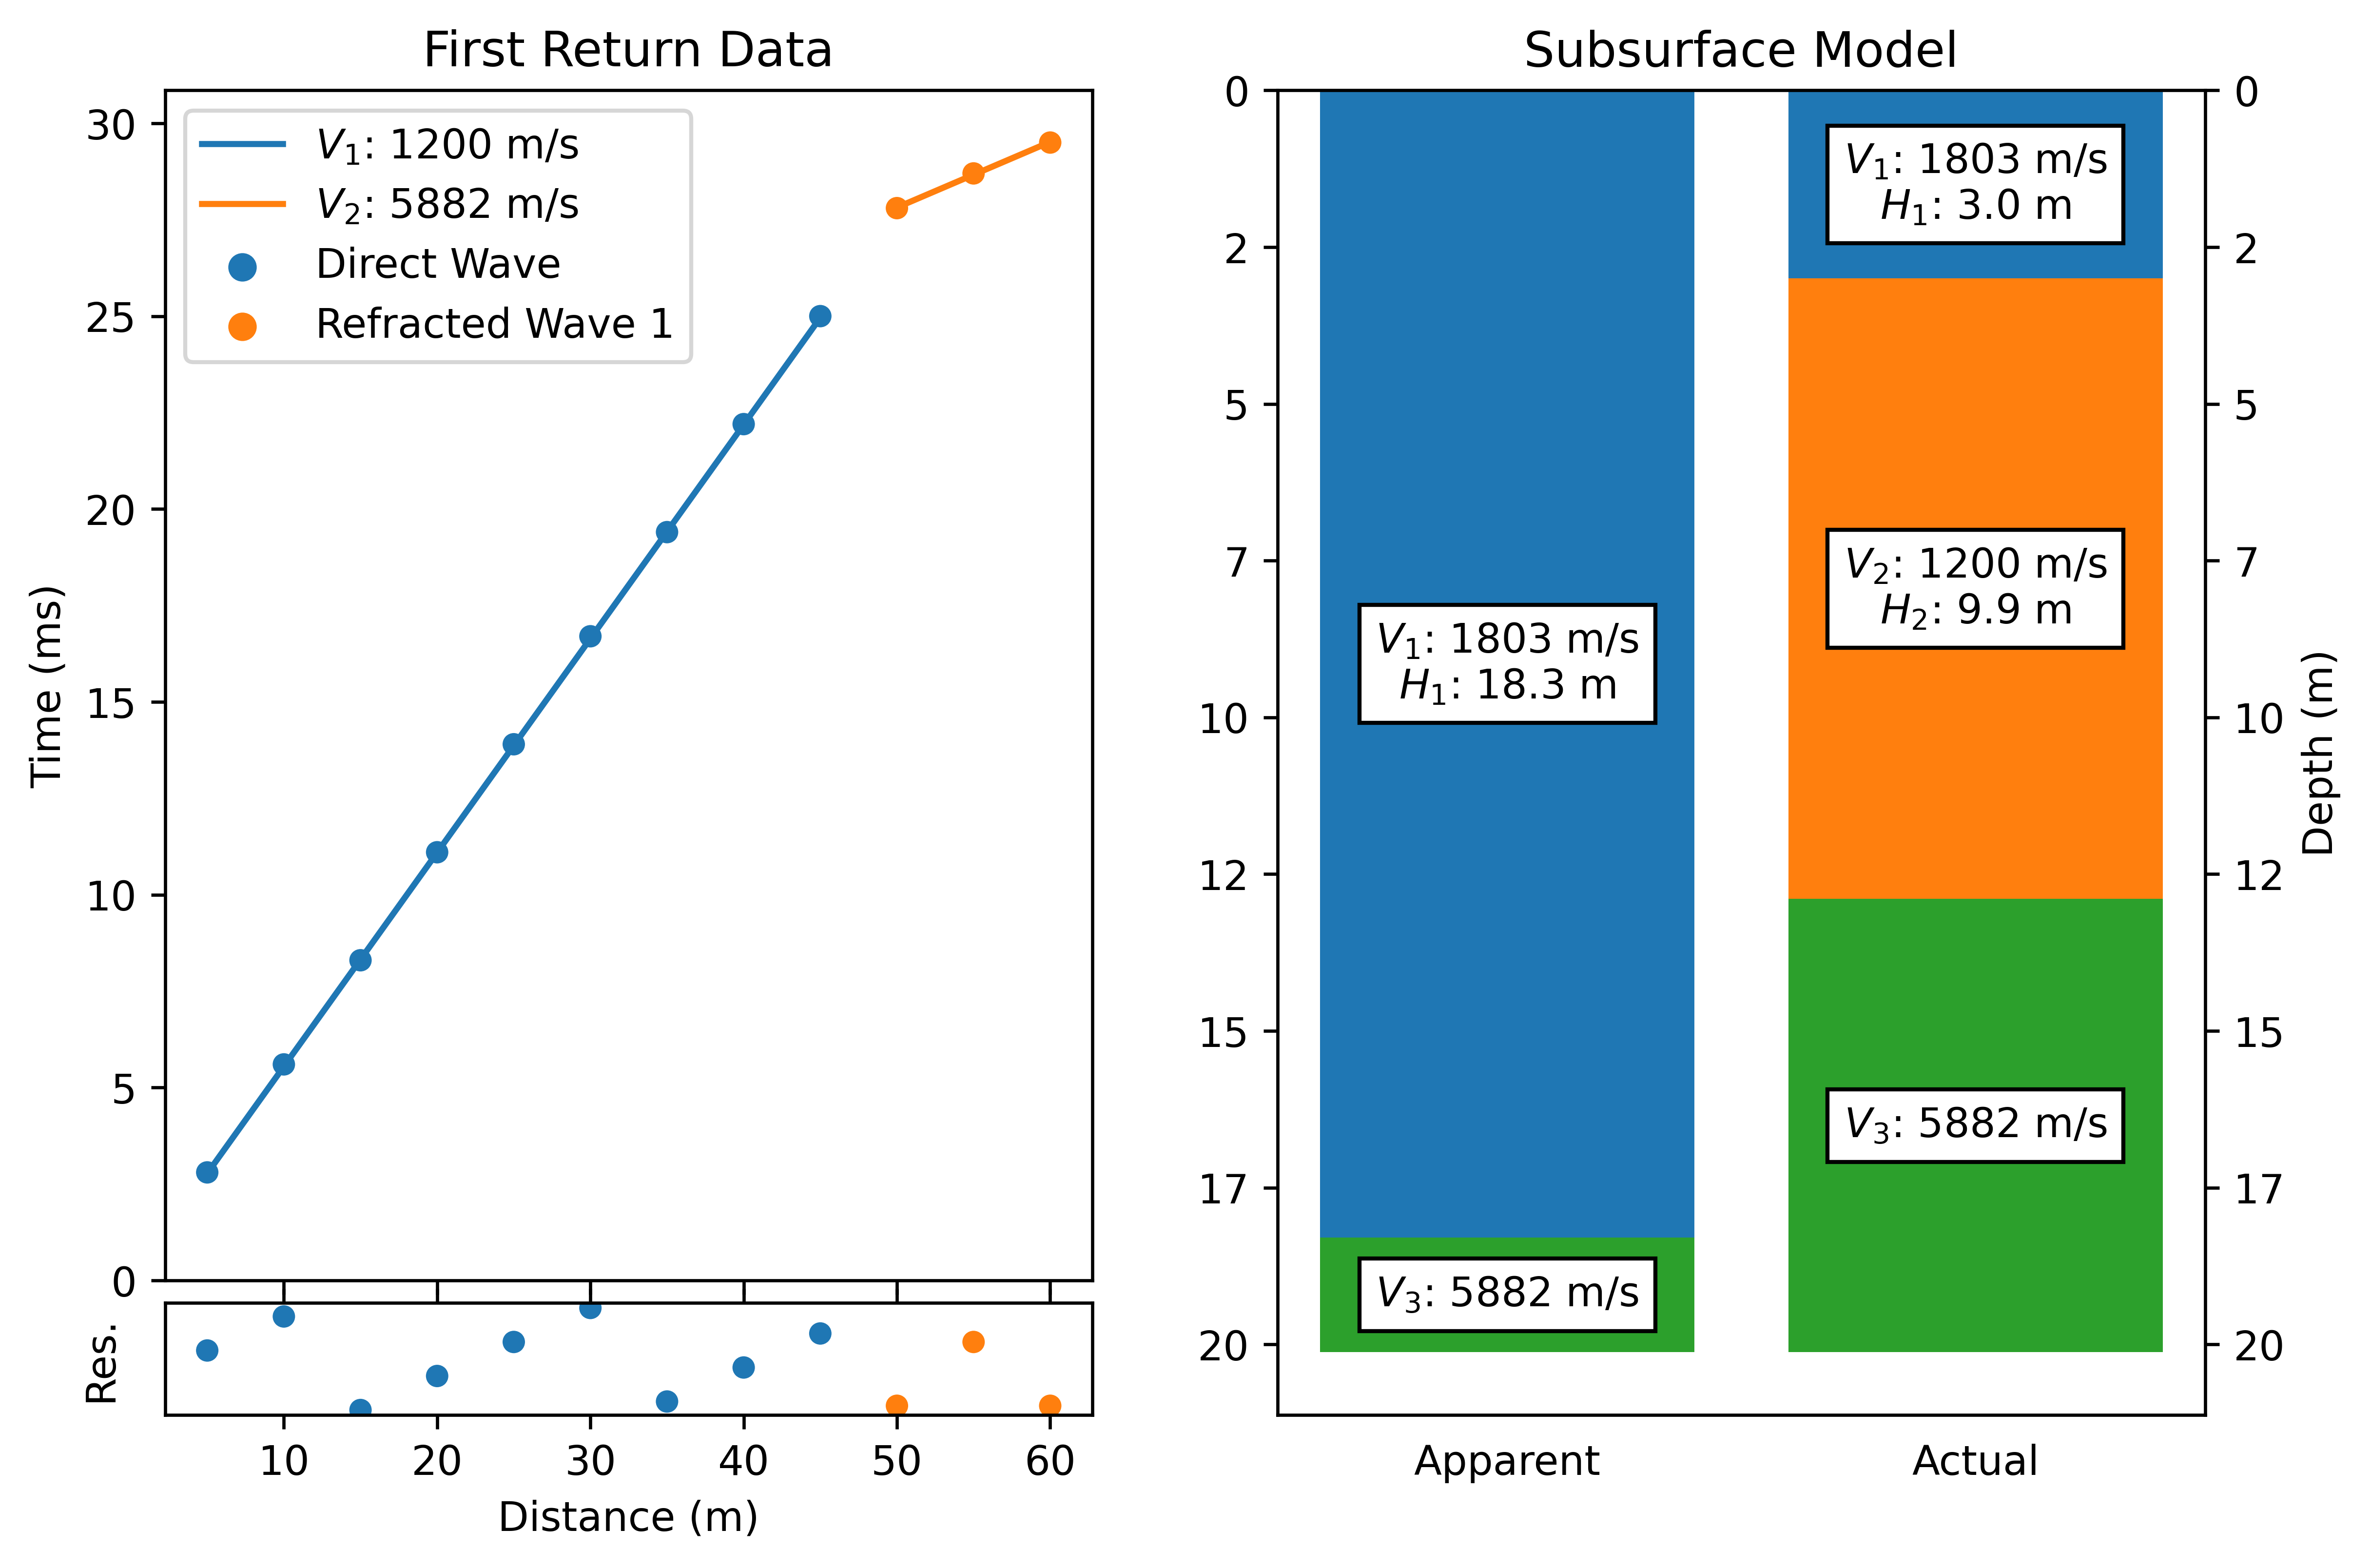

In [23]:
data_Q3 = np.array([
    [5, 2.8],
    [10, 5.6],
    [15, 8.3],
    [20, 11.1],
    [25, 13.9],
    [30, 16.7],
    [35, 19.4],
    [40, 22.2],
    [45, 25.0],
    [50, 27.8],
    [55, 28.7],
    [60, 29.5]
])

# convert ms to s 
data_Q3[:,1] = data_Q3[:,1] / 1000

trace_Q3 = RefractTrace(data_Q3)
trace_Q3.setup_model(xt_breaks = [9])
trace_Q3.model()
trace_Q3.model_hidden_layer(depth_to_hidden=3, hidden_layer_velocity=1200)
trace_Q3.print_model()
trace_Q3.plot()

<ipython-input-18-761c0265479e>:35: RuntimeWarning: divide by zero encountered in double_scalars
  return sqrt(vn ** 2 - vk ** 2) / (vn * vk)
<ipython-input-18-761c0265479e>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([int(1000*tick) for tick in time_ticks])
<ipython-input-18-761c0265479e>:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([int(abs(tick)) for tick in depth_ticks])


Layer 1: Thickness = 10.002083116364648 Velocity = 500.0 m
Layer 2: Thickness = 19.99045420675064 Velocity = 2500.0 m
Layer 3: Thickness = 0.0 Velocity = 3999.999999999998 m
Note that bottom layer thickness is as shown on the model, this number could be theoretically infinite.


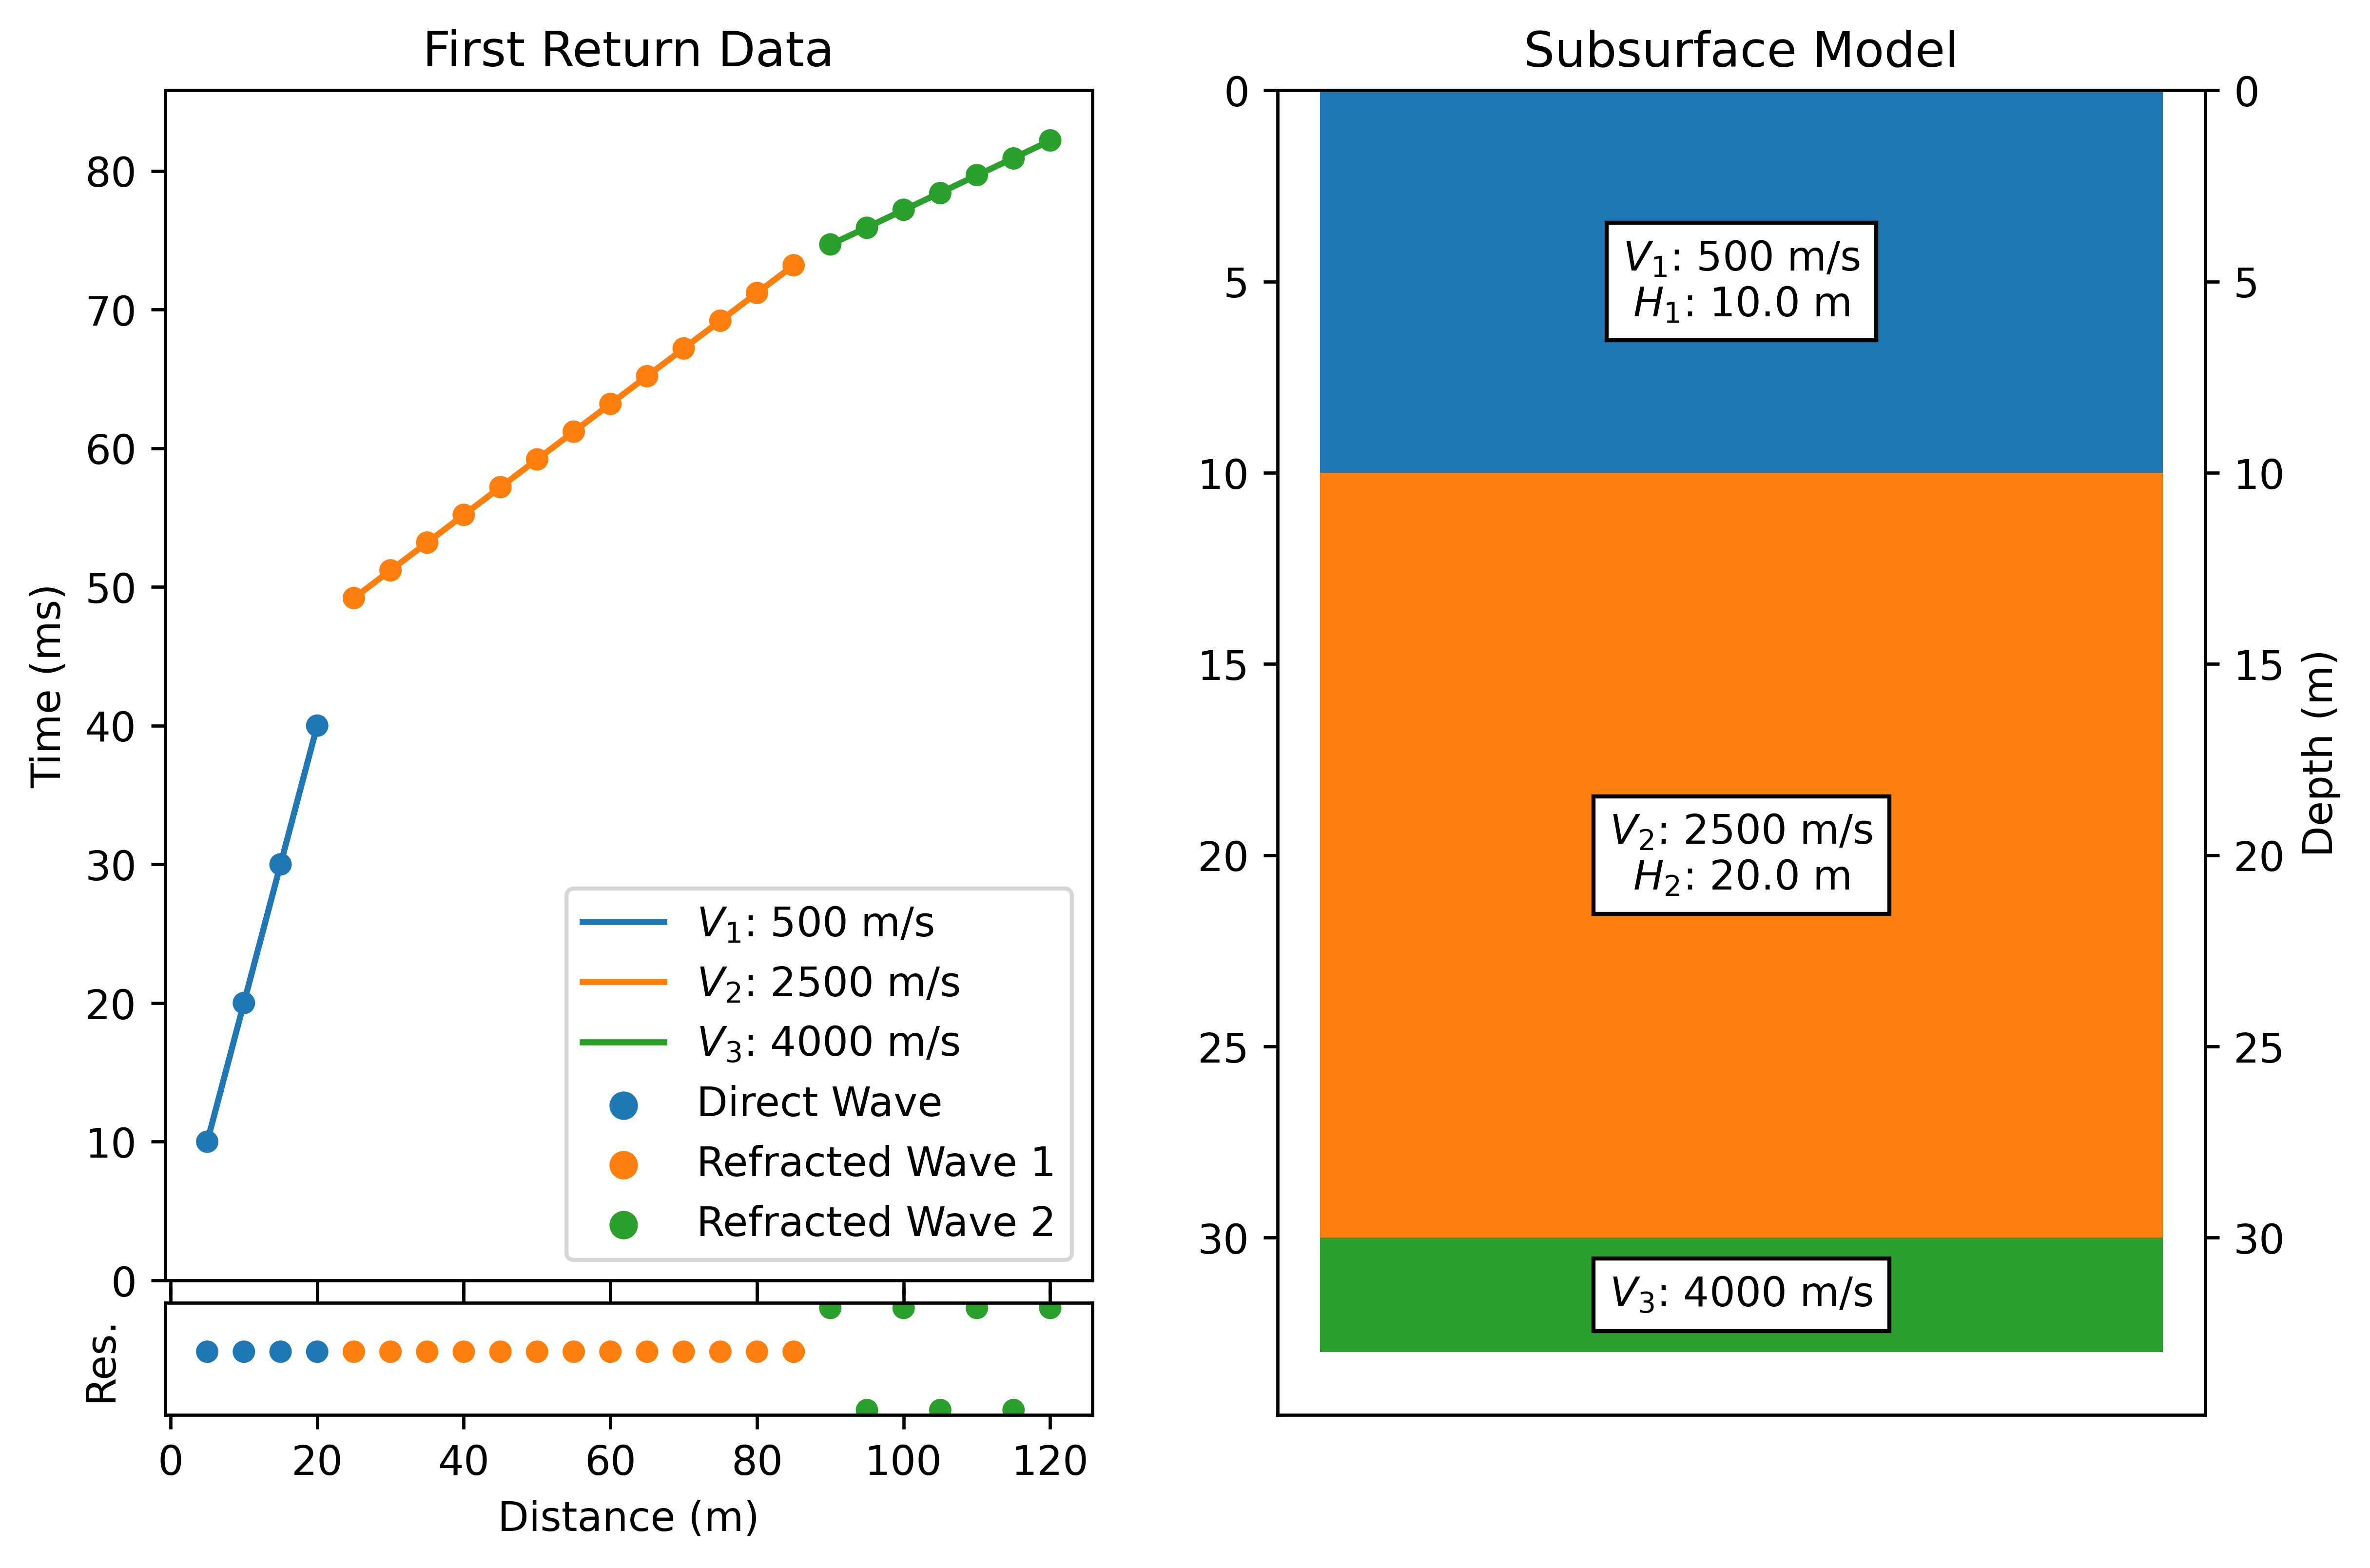

In [21]:
data_TR = np.array([
    [  5. ,  10. ],
    [ 10. ,  20. ],
    [ 15. ,  30. ],
    [ 20. ,  40. ],
    [ 25. ,  49.2],
    [ 30. ,  51.2],
    [ 35. ,  53.2],
    [ 40. ,  55.2],
    [ 45. ,  57.2],
    [ 50. ,  59.2],
    [ 55. ,  61.2],
    [ 60. ,  63.2],
    [ 65. ,  65.2],
    [ 70. ,  67.2],
    [ 75. ,  69.2],
    [ 80. ,  71.2],
    [ 85. ,  73.2],
    [ 90. ,  74.7],
    [ 95. ,  75.9],
    [100. ,  77.2],
    [105. ,  78.4],
    [110. ,  79.7],
    [115. ,  80.9],
    [120. ,  82.2]])

data_TR[:,1] = data_TR[:,1] / 1000

trace_TR = RefractTrace(data_TR)
trace_TR.setup_model(xt_breaks=[4,17])
trace_TR.model()

trace_TR.print_model()
trace_TR.plot()

<ipython-input-18-761c0265479e>:35: RuntimeWarning: divide by zero encountered in double_scalars
  return sqrt(vn ** 2 - vk ** 2) / (vn * vk)
<ipython-input-18-761c0265479e>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([int(1000*tick) for tick in time_ticks])
<ipython-input-18-761c0265479e>:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([int(abs(tick)) for tick in depth_ticks])


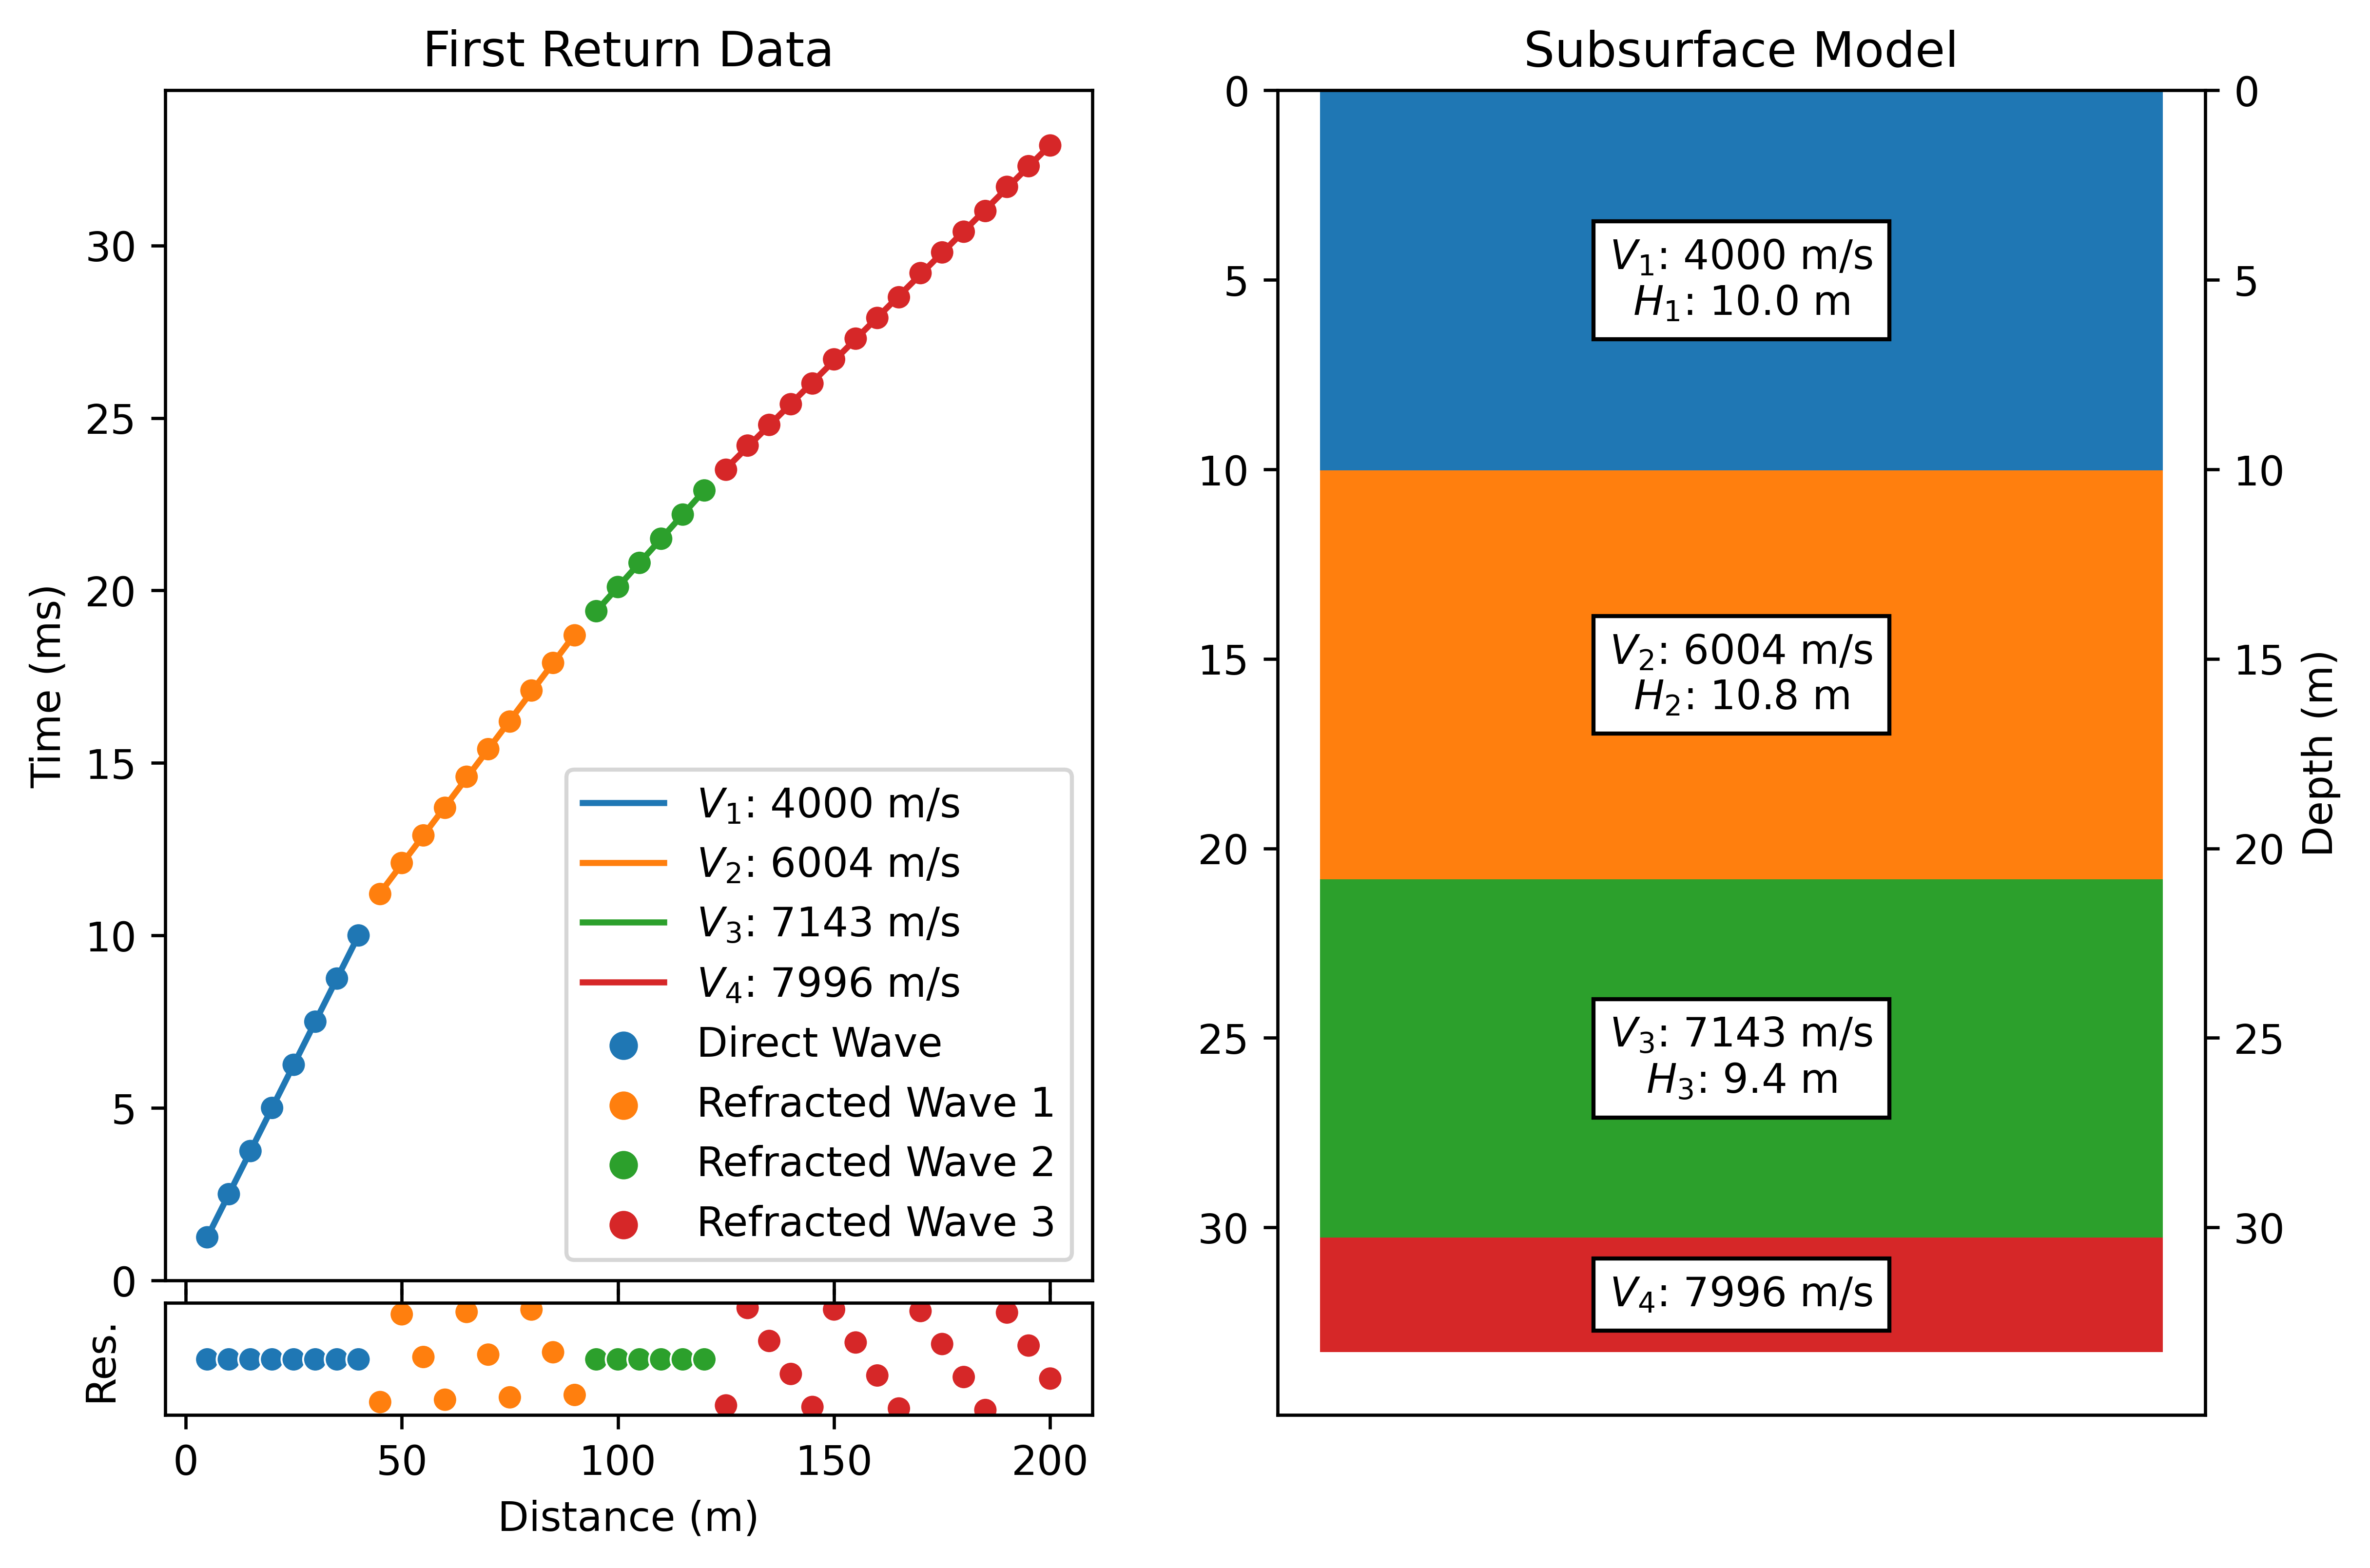

In [22]:
x = np.arange(5,205,5)
t = [1.25,2.5,3.75,5,6.25,7.5,8.75,10,11.2,12.1,12.9,13.7,14.6,15.4,16.2,17.1,17.9,18.7,19.4,20.1,20.8,21.5,22.2,22.9,23.5,24.2,24.8,25.4,26,26.7,27.3,27.9,28.5,29.2,29.8,30.4,31.0,31.7,32.3,32.9]

data_test = np.array([[x[i], t[i]] for i in range(len(x))])

data_test[:,1] = data_test[:,1] / 1000

trace_TR = RefractTrace(data_test)

trace_TR.setup_model(xt_breaks=[8, 18, 24])
trace_TR.model()

trace_TR.plot()
# trace_TR.print_model()



In [17]:
class RawReturns():

    def __init__(self, xt_pairs: list) -> None:
        # Unpack x-t pairs to separate arrays
        self.x, self.t = xt_pairs.T

        self.num_geophones = len(self.x)
        self.t_calculated = self.t.copy() # initialize

class SegmentedReturns():

    def __init__(self, raw_returns, xt_breaks) -> None:
        self.num_segments = len(xt_breaks) + 1

        # labels for plotting
        self.label = [f'Refracted Wave {i}' for i in range(self.num_segments)]
        self.label[0] = 'Direct Wave'
        self.label_code = np.zeros(raw_returns.num_geophones)

        # Model boundaries
        self.num_segments = len(xt_breaks) + 1
        self.xt_breaks = np.concatenate(([0], xt_breaks, [raw_returns.num_geophones]))

        # Initialize model (interpretation) variables
        self.velocity = np.zeros(self.num_segments)
        self.thickness = np.zeros(self.num_segments)

class Model():
    def __init__(self, segmented_returns) -> None:
        self.hidden = False
        self.xt_breaks = segmented_returns.xt_breaks

        self.num_layers = segmented_returns.num_segments

        # Regression & Layer thickness(es)
        for i in range(segmented_returns.num_segments):

            # Define x, t interval for regression
            start, stop = self.xt_breaks[i], self.xt_breaks[i+1]
            x_segment, t_segment = self.x[start:stop], self.t[start:stop]

            # Linear regression matrix
            x_matrix = np.column_stack([x_segment, np.ones(len(x_segment))])

            # Perform regression using scikit-learn
            reg = LinearRegression(fit_intercept= (i > 0))
            reg.fit(x_matrix, t_segment)
        
            # Add calculated variables to corresponding layer 
            self.velocity[i] = 1 / reg.coef_[0]

            # Calculate overlying layer thickness
            sum_term = 2 * np.sum([self.thickness[k] * self.velocity_term(k, i) for k in range(i)])
            self.thickness[i-1] = (reg.intercept_ - sum_term) / (2 * self.velocity_term(i-1, i))

            # Calculate regression t values for geophones in this segment
            self.t_calculated[start:stop] = [reg.coef_[0] * x + reg.intercept_ for x in x_segment]

            self.label_code[start:stop] = i

    # for calculations
    def velocity_term(self, k, n):
        vk = self.velocity[k]
        vn = self.velocity[n]
        if isclose(vn, vk, rel_tol=0.000001):
            raise ValueError('One or more layer boundaries does not reflect a noticeable velocity contrast. Try removing boundaries.')
        elif vn < vk:
            raise ValueError('Critical refraction cannot occur.')
        else:
            return sqrt(vn ** 2 - vk ** 2) / (vn * vk)

class RegularModel(Model):
    def __init__(self) -> None:
        pass

class InvertedModel(Model):
    def __init__(self) -> None:
        pass
